In [447]:
import scGAM as scGAM
import gseapy

In [448]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import numpy as np
import scanpy.external as sce

In [449]:
from pygam import LinearGAM, s
import numpy as np
import pandas as pd
import time
from collections import OrderedDict
from joblib import delayed, Parallel
from sklearn.preprocessing import StandardScaler
import scanpy as sc
import seaborn as sns

In [450]:
sc.settings.verbosity = 3  
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))

-----
anndata     0.9.1
scanpy      1.9.3
-----
Cython                      0.29.33
PIL                         9.1.1
anyio                       NA
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
brotli                      NA
certifi                     2022.12.07
cffi                        1.15.0
charset_normalizer          2.0.7
cloudpickle                 2.2.0
colorama                    0.4.6
cycler                      0.10.0
cython                      0.29.33
cython_runtime              NA
cytoolz                     0.12.1
dask                        2023.5.1
dateutil                    2.8.2
debugpy                     1.5.0
decorator                   5.1.1
defusedxml                  0.7.1
dill                        0.3.6
entrypoints                 0.3
fasteners                   0.18
fastjsonschema              NA
fontTools                   4.38.0
google                      NA
gsea

In [451]:
samples_dict = {"Immature": "A0021_043", "0hr": "A0008_041", "1hr": "A0021_044", "4hr": "A0008_045", "4hr_replicate": "A0021_042", "6hr": "A0021_045", "8hr": "A0008_044", "8hr_replicate": "A0021_038", "11hr": "A0008_046", "12hr": "A0021_046"}

In [452]:
s_genes = list(pd.read_csv("./../../MouseInfection/s.genes.txt")["x"])
g2m_genes = list(pd.read_csv("./../../MouseInfection/g2m.genes.txt")["x"])
print(s_genes)
print(g2m_genes)

['Mcm4', 'Exo1', 'Slbp', 'Gmnn', 'Cdc45', 'Msh2', 'Mcm6', 'Rrm2', 'Pold3', 'Blm', 'Ubr7', 'Mcm5', 'Clspn', 'Hells', 'Nasp', 'Rpa2', 'Rad51ap1', 'Tyms', 'Rrm1', 'Rfc2', 'Prim1', 'Brip1', 'Usp1', 'Ung', 'Pola1', 'Mcm2', 'Fen1', 'Tipin', 'Pcna', 'Cdca7', 'Uhrf1', 'Casp8ap2', 'Cdc6', 'Dscc1', 'Wdr76', 'E2f8', 'Dtl', 'Ccne2', 'Atad2', 'Gins2', 'Chaf1b', 'Pcna-ps2']
['Nuf2', 'Psrc1', 'Ncapd2', 'Ccnb2', 'Smc4', 'Lbr', 'Tacc3', 'Cenpa', 'Kif23', 'Cdca2', 'Anp32e', 'G2e3', 'Cdca3', 'Anln', 'Cenpe', 'Gas2l3', 'Tubb4b', 'Cenpf', 'Dlgap5', 'Hjurp', 'Cks1brt', 'Gtse1', 'Bub1', 'Birc5', 'Ube2c', 'Rangap1', 'Hmmr', 'Ect2', 'Tpx2', 'Ckap5', 'Cbx5', 'Nek2', 'Ttk', 'Cdca8', 'Nusap1', 'Ctcf', 'Cdc20', 'Cks2', 'Mki67', 'Tmpo', 'Ckap2l', 'Aurkb', 'Kif2c', 'Cdk1', 'Kif20b', 'Top2a', 'Aurka', 'Ckap2', 'Hmgb2', 'Cdc25c', 'Ndc80', 'Kif11']


In [571]:
granulosa = sc.read_h5ad("./../pyobjs/granulosa1.h5ad")
granulosa.uns['log1p']["base"] = None
print(granulosa.shape)

(76346, 31053)


In [454]:
granulosa_temp = granulosa[granulosa.obs["Sample"] == "0hr"]
granulosa_temp = granulosa_temp[granulosa_temp.obs["Follicle_type"] == "Antral"]
granulosa_temp.shape

(2688, 31053)

In [390]:
correlation_df = pd.read_csv("./../pyobjs/correlations_magic_full_oocyte_pred.csv", index_col=0)
len(correlation_df[correlation_df.correlation < 0.5].index.values)
print(correlation_df.loc["Inhbb",])
print(correlation_df.loc["Kctd14",])

gene              Inhbb
correlation   -0.008453
means          0.831012
dispersions    2.930564
Name: Inhbb, dtype: object
gene             Kctd14
correlation    0.283641
means           0.76717
dispersions     3.17499
Name: Kctd14, dtype: object


In [391]:
granulosa_temp = granulosa_temp[:,correlation_df[correlation_df.correlation < 0.5].index.values]
granulosa_temp.shape

(2688, 19288)

In [392]:
sc.tl.rank_genes_groups(granulosa_temp, groupby="granulosa_celltypes_reduced", groups=['GC_Mural-(Antral)', 'GC_Cumulus-(Mixed)'], key_added="mural_vs_cumulus")

ranking genes
    finished: added to `.uns['mural_vs_cumulus']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/mm2937/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [395]:
granulosa_temp.obs["granulosa_celltypes_reduced"].value_counts()

GC_Mural-(Antral)       2403
GC_Mural-(Atretic)        86
GC_Mural-(Preantral)      81
GC_Cumulus-(Mixed)        81
GC_Lytic-(Lytic)          37
Name: granulosa_celltypes_reduced, dtype: int64

In [397]:
cumulus_genes = sc.get.rank_genes_groups_df(granulosa_temp, key="mural_vs_cumulus", group = 'GC_Cumulus-(Mixed)', log2fc_min=1.5, pval_cutoff=0.01)
cumulus_genes = cumulus_genes.sort_values(by = "scores", ascending= False)
cumulus_genes.head(20)

names    scores  logfoldchanges         pvals     pvals_adj
0     Rbbp7  6.123767        1.639315  2.632979e-08  7.468366e-07
1      Rgs2  6.058232        2.004394  3.731905e-08  1.026833e-06
2  Hsp90aa1  5.312865        2.025886  8.876584e-07  1.809847e-05
3      Ggct  4.274232        2.776082  5.181688e-05  7.093286e-04
4    Tubb4b  4.185415        1.502879  6.986600e-05  9.450038e-04
5      Ybx3  3.598188        1.810380  5.456011e-04  6.030690e-03

/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'FollicleNumber' as categorical


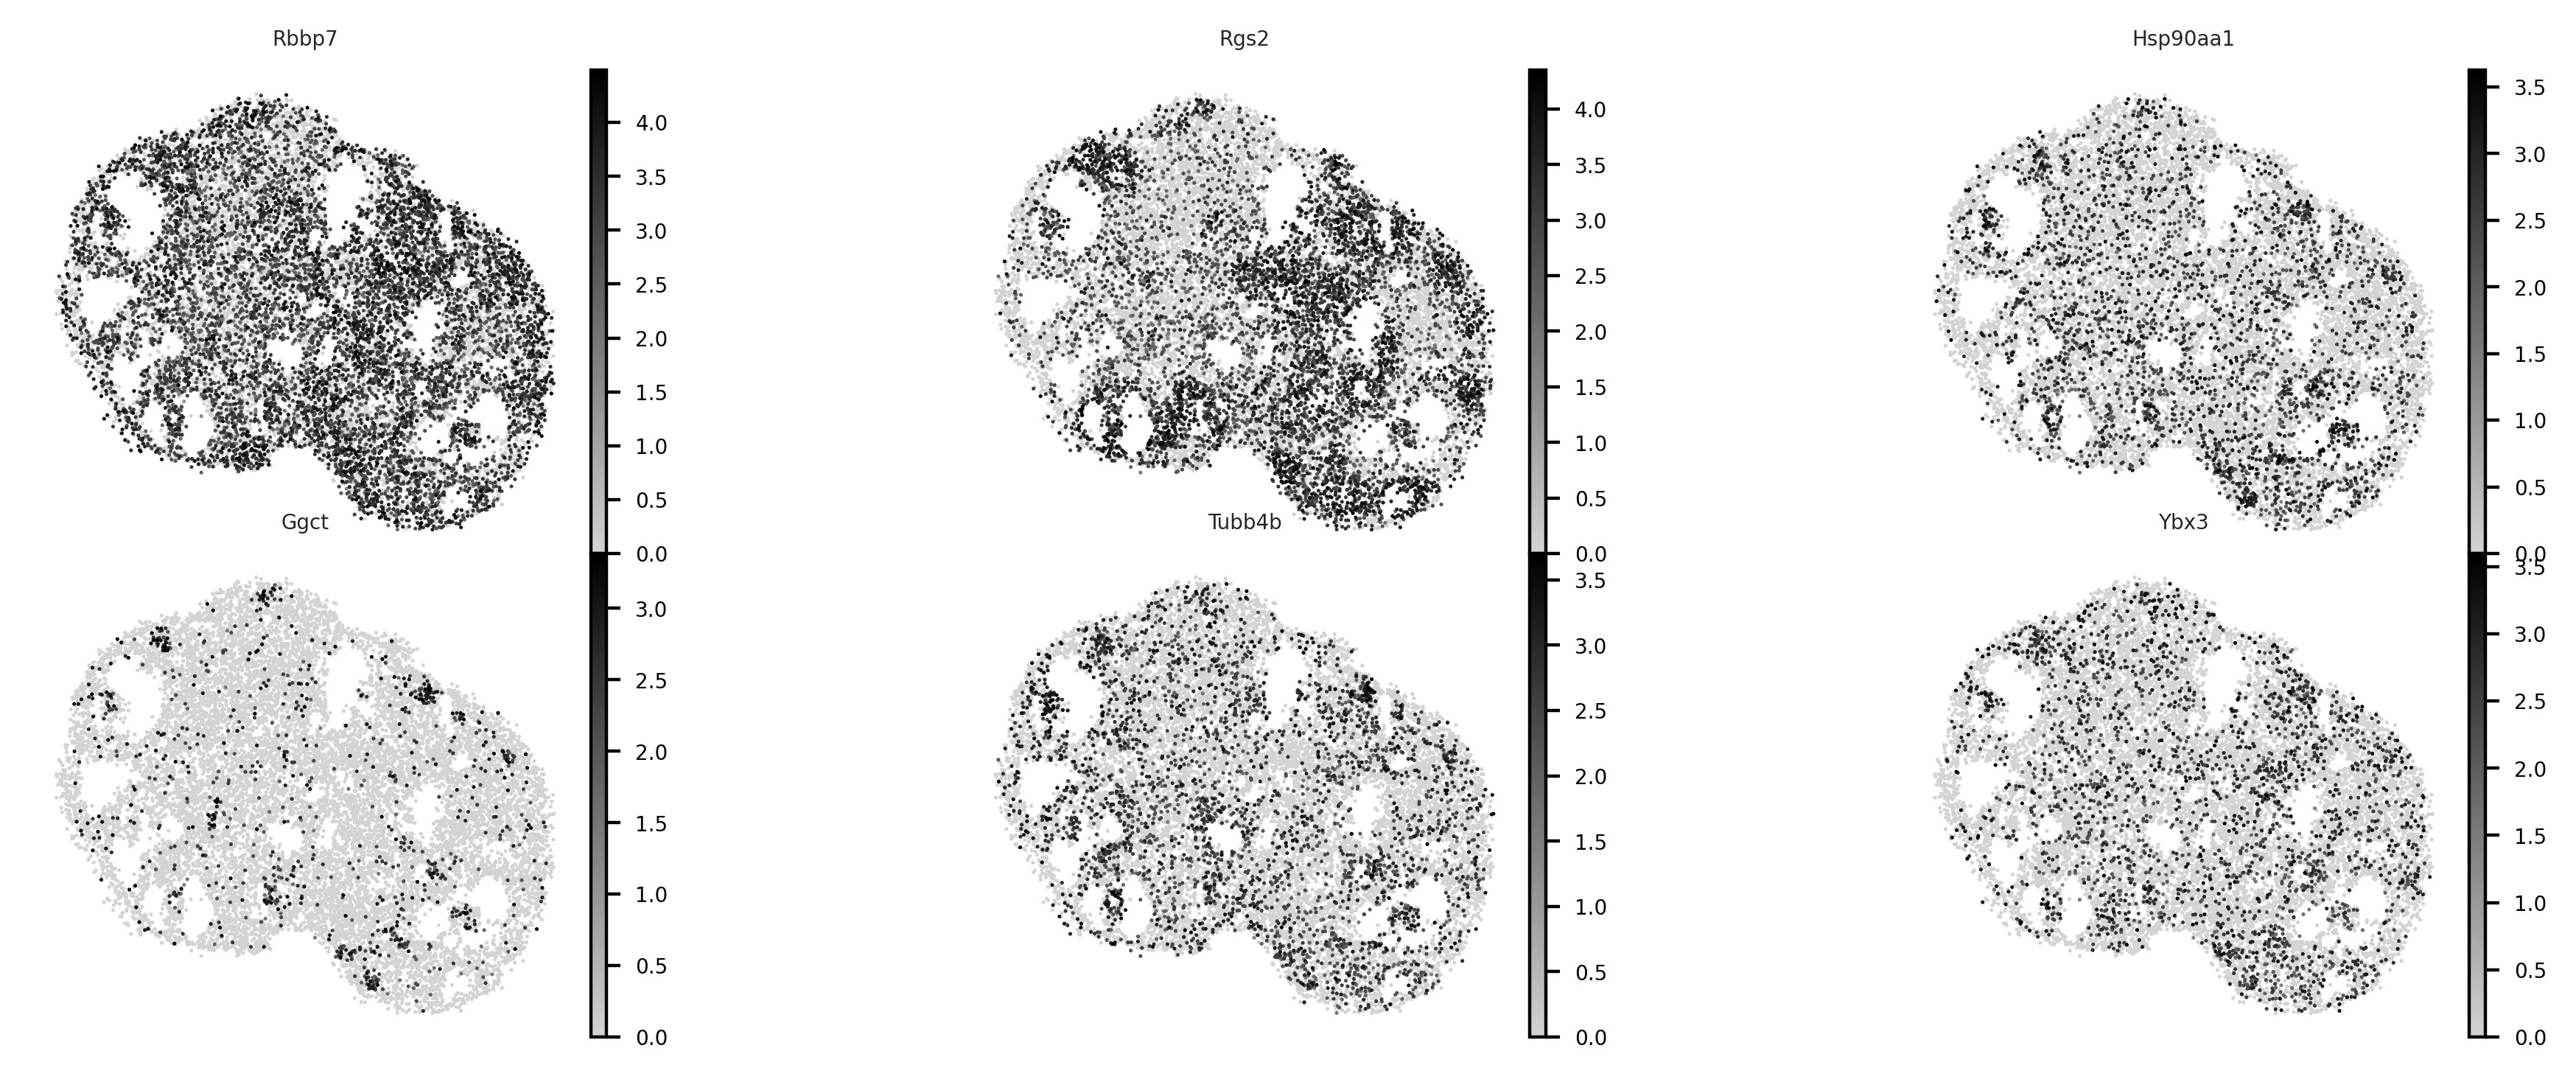

In [398]:
sc.settings.set_figure_params(dpi=200, dpi_save= 300, fontsize=5, facecolor='white', frameon=False, figsize=(4.0, 2.0), vector_friendly = True, transparent=True, format="pdf")
sc.pl.spatial(adata_ovary_combined[adata_ovary_combined.obs["Sample"] == "0hr"], color = cumulus_genes.head(6)["names"], wspace= 0.0, hspace= 0.0, spot_size = 30, ncols=3, frameon=False, cmap=sns.blend_palette(["lightgrey", sns.xkcd_rgb["black"]], as_cmap=True), vmax='p99.2')  

In [572]:
granulosa_mural = granulosa[granulosa.obs["granulosa_celltypes_reduced"] == "GC_Cumulus-(Mixed)"]
granulosa_mural_subset = granulosa_mural[granulosa_mural.obs["Follicle_type"] == "Antral"]
granulosa_mural_subset.shape

(2858, 31053)

In [573]:
granulosa_mural_subset = granulosa_mural_subset[~granulosa_mural_subset.obs["Sample"].isin(["4hr", "8hr_replicate"])]
granulosa_mural_subset.shape

(2280, 31053)

In [574]:
sc.pp.highly_variable_genes(granulosa_mural_subset, batch_key="Sample", min_disp=0.5, min_mean=0.5)
gene_list = list(granulosa_mural_subset.var_names[granulosa_mural_subset.var.highly_variable])
len(gene_list)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/mm2937/.local/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:540: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}


225

In [575]:
granulosa_mural_subset.obs["timepoint_index"] = granulosa_mural_subset.obs["Sample"]
celltypes = {'Immature': 0, 
             '0hr': 1, 
            '1hr': 2, 
#             '4hr': 3, 
            '4hr_replicate': 3, 
            '6hr': 4, 
            '8hr': 5,
#             '8hr_replicate': 5, 
            '11hr': 6,
            '12hr': 7}
granulosa_mural_subset.obs["timepoint_index"] = granulosa_mural_subset.obs["timepoint_index"].map(celltypes)
granulosa_mural_subset.obs["timepoint"] = granulosa_mural_subset.obs["Sample"]
celltypes = {'Immature': -1, 
             '0hr': 0, 
            '1hr': 1, 
#             '4hr': 4, 
            '4hr_replicate': 4, 
            '6hr': 6, 
            '8hr': 8,
#             '8hr_replicate': 8, 
            '11hr': 11,
            '12hr': 12}
granulosa_mural_subset.obs["timepoint"] = granulosa_mural_subset.obs["timepoint"].map(celltypes)
granulosa_mural_subset.obs["timepoint"] = granulosa_mural_subset.obs["timepoint"].astype(int)

In [576]:
mural_path = ['GC_Cumulus-(Mixed)']
trend_results = scGAM.compute_gene_trends(granulosa_mural_subset, var_key="timepoint", n_bins = 0, genes = gene_list, use_raw = False, lineages_paths={"Cumulus":mural_path}, group_by = "granulosa_celltypes_reduced")

Preparing...
Cumulus :  ['GC_Cumulus-(Mixed)']
Time for processing Cumulus: 1.547046462694804 minutes


In [577]:
trends = trend_results['Cumulus']['trend']

In [462]:
trends.to_csv("./../pyobjs/cumulus_granulosa_gene_trends_timepoint_discrete.csv")

In [661]:
trends = pd.read_csv("./../pyobjs/cumulus_granulosa_gene_trends_timepoint_discrete.csv", index_col=0)

In [662]:
clusters = scGAM.Agglomerative_cluster_gene_trends_from_lineage(trends, n_clusters=4, scale=True)
clusters.value_counts()

0    120
1     57
3     29
2     19
dtype: int64

In [663]:
def plot_gene_expression_trend_clusters(trends, cluster_ids, scale = True):
    if scale: 
        trends_df = pd.DataFrame(
            StandardScaler().fit_transform(trends.T).T,
            index=trends.index,
            columns=trends.columns,
        ).T
    else:
        trends_df = trends.T
    trends_df = trends_df.stack().reset_index().rename(columns = {"level_0": "timepoint", "level_1":"Gene", 0: "Expression"})
    trends_df["Cluster"] = [cluster_ids[x] for x in trends_df["Gene"]]
    return trends_df

In [666]:
trends_df = plot_gene_expression_trend_clusters(trends = trends, cluster_ids=clusters, scale=True)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


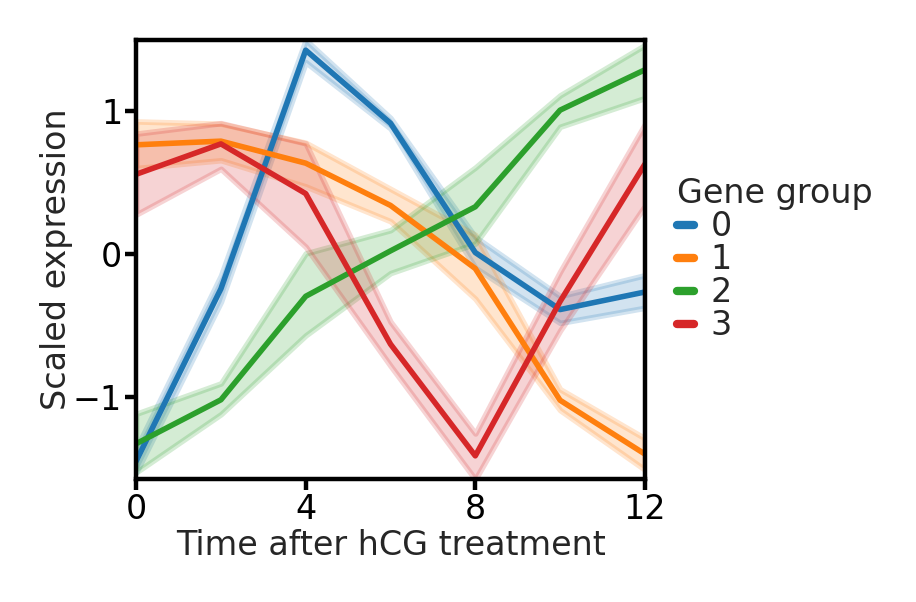

In [656]:
sc.settings.set_figure_params(dpi=200, dpi_save=200, fontsize=6, facecolor='white', frameon=True, figsize=(1.5, 1.5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Cluster", palette="tab10", lw = 1, ax=ax)
g.set_xticks([0,2,4,6])
plt.legend(ncol=1, prop={'size': 6}, loc = 6, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 6, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.50))
ax.get_legend().set_title("Gene group")
ax.set_xlabel("Hours after hCG treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
fig.savefig("./figures/cumulus_gene_group_trends.pdf")

In [667]:
clusters.loc["Nupr1",]

2

In [668]:
def plot_gene_expression_trends(trends, genes, scale = True):
    if scale: 
        trends_df = pd.DataFrame(
            StandardScaler().fit_transform(trends.T).T,
            index=trends.index,
            columns=trends.columns,
        ).T[genes]
    else:
        trends_df = trends.T[genes]
    trends_df = trends_df.stack().reset_index().rename(columns = {"level_0": "timepoint", "level_1":"Gene", 0: "Expression"})
    return trends_df

In [669]:
trends_df = plot_gene_expression_trends(trends = trends, genes=granulosa_mural_subset.var.loc[clusters[clusters == 2].index.values,:].sort_values(by = "dispersions_norm", ascending = False).index.values[0:10], scale=True)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


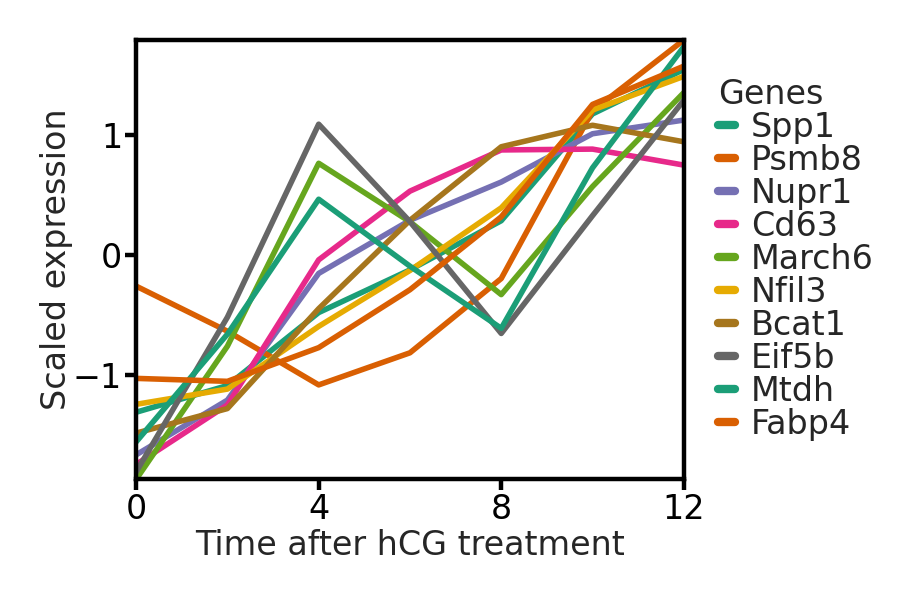

In [670]:
sc.settings.set_figure_params(dpi=200, fontsize=6, facecolor='white', frameon=True, figsize=(5, 5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Gene", palette="Dark2", lw = 1, ax=ax)
g.set_xticks([0,2,4,6])
plt.legend(ncol=1, prop={'size': 6}, loc = 6, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 6, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.5))
ax.get_legend().set_title("Genes")
ax.set_xlabel("Time after hCG treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
fig.savefig("./figures/cumulus_increasing_trends.pdf")

In [586]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Mouse')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease

In [587]:
# # Some databases of interest:
# GO_Biological_Process_2021
# GO_Biological_Process_2017b
# KEGG_2019_Human
# KEGG_2019_Mouse
# WikiPathways_2019_Human
# WikiPathways_2019_Mouse

In [671]:
import gseapy
enr_res = gseapy.enrichr(gene_list=list(clusters[clusters == 2].index), 
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2017b'],
#                      description='pathway', 
                     cutoff = 0.5)

In [672]:
GO_results = enr_res.results
GO_results["-log p-value"] =  -1 * np.log10(GO_results["Adjusted P-value"]) 
GO_results["Term"] = [x.split(" (")[0] for x in GO_results["Term"]]
GO_results[0:10]

Gene_set  \
0  GO_Biological_Process_2017b   
1  GO_Biological_Process_2017b   
2  GO_Biological_Process_2017b   
3  GO_Biological_Process_2017b   
4  GO_Biological_Process_2017b   
5  GO_Biological_Process_2017b   
6  GO_Biological_Process_2017b   
7  GO_Biological_Process_2017b   
8  GO_Biological_Process_2017b   
9  GO_Biological_Process_2017b   

                                                Term Overlap   P-value  \
0                         androgen catabolic process    2/15  0.000089   
1                                 myofibril assembly    2/28  0.000318   
2  extracellular matrix organization involved in ...   3/143  0.000319   
3  extracellular matrix organization in marginal ...   3/143  0.000319   
4                  extracellular matrix organization   3/143  0.000319   
5                        biofilm matrix organization   3/143  0.000319   
6                 cellulose microfibril organization   3/143  0.000319   
7                    fibronectin fibril organization   3/144  0.000325   
8                     basement membrane organization   3/144  0.000325   
9  gene expression involved in extracellular matr...   3/146  0.000339   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.021323            0                     0  180.705882   
1          0.021323            0                     0   90.294118   
2          0.021323            0                     0   26.572768   
3          0.021323            0                     0   26.572768   
4          0.021323            0                     0   26.572768   
5          0.021323            0                     0   26.572768   
6          0.021323            0                     0   26.572768   
7          0.021323            0                     0   26.382979   
8          0.021323            0                     0   26.382979   
9          0.021323            0                     0   26.011364   

   Combined Score           Genes  -log p-value  
0     1685.184229   SPP1;HSD17B11      1.671154  
1      727.046819       SDC1;F11R      1.671154  
2      213.928943  DAG1;SPP1;F11R      1.671154  
3      213.928943  DAG1;SPP1;F11R      1.671154  
4      213.928943  DAG1;SPP1;F11R      1.671154  
5      213.928943  DAG1;SPP1;F11R      1.671154  
6      213.928943  DAG1;SPP1;F11R      1.671154  
7      211.861391  DAG1;SPP1;F11R      1.671154  
8      211.861391  DAG1;SPP1;F11R      1.671154  
9      207.824593  DAG1;SPP1;F11R      1.671154

/tmp/ipykernel_1212780/3847498217.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)
/tmp/ipykernel_1212780/3847498217.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
/tmp/ipykernel_1212780/3847498217.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


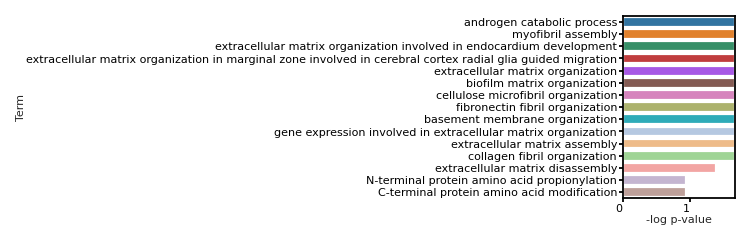

In [590]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=5, facecolor='white', frameon=True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize=(0.9,1.5))
plt.rc('font', size=5)
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
ax.set_axisbelow(True)
plt.grid(b=None)
g = sns.barplot(y = "Term", x = "-log p-value", data= GO_results[0:15], ax=ax)
# from textwrap import wrap
# labels = [x.get_text() for x in ax.get_yticklabels()]
# labels = ['\n'.join(wrap(l, 40)) for l in labels]
# # print(labels)
# ax.set_yticklabels(labels, rotation=0, horizontalalignment='right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
ax.set_xlabel("-log p-value", labelpad=0.5)
ax.set_ylabel("Term", labelpad=0.0)
plt.tight_layout()
plt.savefig("./figures/cumulus_increasing_trends_go.pdf")

In [606]:
trends_df = plot_gene_expression_trends(trends = trends, genes=granulosa_mural_subset.var.loc[clusters[clusters == 0].index.values,:].sort_values(by = "dispersions_norm", ascending = False).index.values[0:10], scale=True)

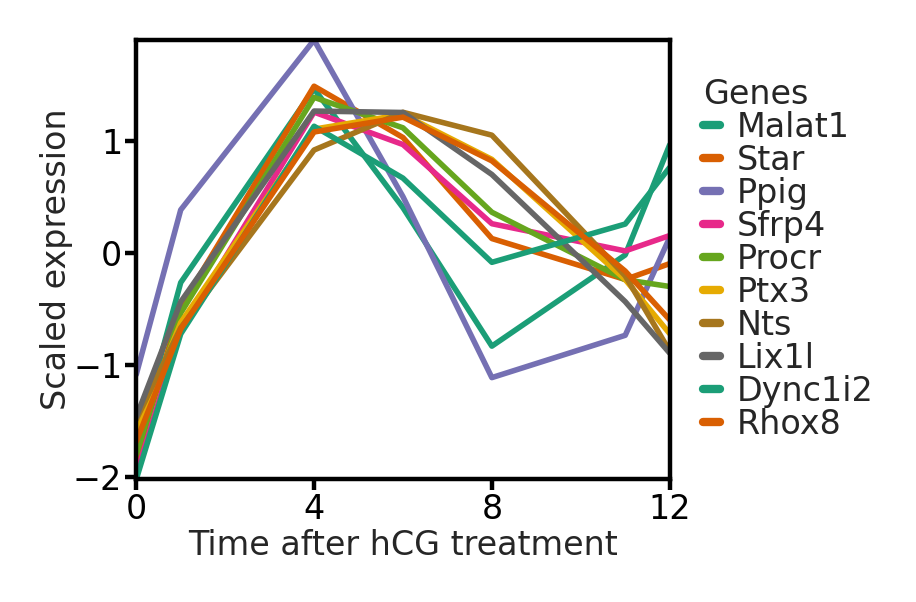

In [607]:
sc.settings.set_figure_params(dpi=200, fontsize=6, facecolor='white', frameon=True, figsize=(5, 5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Gene", palette="Dark2", lw = 1, ax=ax)
g.set_xticks([0,4,8,12])
plt.legend(ncol=1, prop={'size': 6}, loc = 6, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 6, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.5))
ax.get_legend().set_title("Genes")
ax.set_xlabel("Time after hCG treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
fig.savefig("./figures/cumulus_early_increase_trends.pdf")

In [594]:
import gseapy
enr_res = gseapy.enrichr(gene_list=list(clusters[clusters == 0].index), 
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2021'],
#                      description='pathway', 
                     cutoff = 0.01)

In [595]:
GO_results = enr_res.results
GO_results["-log p-value"] =  -1 * np.log10(GO_results["Adjusted P-value"]) 
GO_results["Term"] = [x.split(" (")[0] for x in GO_results["Term"]]
GO_results[0:15]

Gene_set  \
0   GO_Biological_Process_2021   
1   GO_Biological_Process_2021   
2   GO_Biological_Process_2021   
3   GO_Biological_Process_2021   
4   GO_Biological_Process_2021   
5   GO_Biological_Process_2021   
6   GO_Biological_Process_2021   
7   GO_Biological_Process_2021   
8   GO_Biological_Process_2021   
9   GO_Biological_Process_2021   
10  GO_Biological_Process_2021   
11  GO_Biological_Process_2021   
12  GO_Biological_Process_2021   
13  GO_Biological_Process_2021   
14  GO_Biological_Process_2021   

                                                 Term Overlap   P-value  \
0        negative regulation of RNA catabolic process     3/9  0.000017   
1                       regulation of mRNA processing    4/36  0.000063   
2      negative regulation of protein kinase activity    5/90  0.000209   
3        regulation of mRNA splicing, via spliceosome    5/90  0.000209   
4   positive regulation of epithelial cell differe...    3/20  0.000223   
5              positive regulation of mRNA processing    3/23  0.000342   
6                           steroid metabolic process   5/104  0.000410   
7                                     mRNA processing   8/300  0.000459   
8                        steroid biosynthetic process    4/65  0.000629   
9                steroid hormone biosynthetic process    3/31  0.000838   
10                 cellular protein metabolic process   9/417  0.000931   
11                                ribosome biogenesis   6/192  0.001069   
12       organic cyclic compound biosynthetic process    3/34  0.001100   
13     regulation of endothelial cell differentiation     2/9  0.001250   
14               collagen-activated signaling pathway     2/9  0.001250   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0           0.018010            0                     0   84.931624   
1           0.032699            0                     0   21.387931   
2           0.046582            0                     0   10.125320   
3           0.046582            0                     0   10.125320   
4           0.046582            0                     0   29.959276   
5           0.059518            0                     0   25.461538   
6           0.059982            0                     0    8.687308   
7           0.059982            0                     0    4.791585   
8           0.073052            0                     0   11.203505   
9           0.087105            0                     0   18.179487   
10          0.087105            0                     0    3.869634   
11          0.087105            0                     0    5.572722   
12          0.087105            0                     0   16.417701   
13          0.087105            0                     0   48.118644   
14          0.087105            0                     0   48.118644   

    Combined Score                                              Genes  \
0       931.583054                                 PHAX;SLIRP;ZCCHC17   
1       207.014608                                SON;DHX9;LARP7;IWS1   
2        85.782014                 CDKN1A;UBASH3B;PRKRIP1;CHP1;CORO1C   
3        85.782014                         RBM25;RBMXL1;SON;NCL;LARP7   
4       251.923769                                   SFRP4;BTG1;VEZF1   
5       203.220931                                    RBMXL1;NCL;PAF1   
6        67.763701                       STAR;SULT1E1;FDX1;PRLR;FDFT1   
7        36.828312    ZRSR2;SNRNP40;SON;ZMAT2;DHX9;THOC3;SNRPD3;TBRG4   
8        82.582520                              STAR;DHCR7;PRLR;FDFT1   
9       128.802177                                    STAR;FDX1;DHCR7   
10       27.007563  VCAN;UBE2I;RPL22;FDX1;STK38;SHISA5;NEDD8;ABCF1...   
11       38.123233                    NOP58;RPL22;SBDS;GLUL;LYAR;RPL7   
12      111.837327                                    STAR;PRLR;FDFT1   
13      321.642595                                         BTG1;VEZF1   
14      321.642595                          

/tmp/ipykernel_1212780/661754289.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)
/tmp/ipykernel_1212780/661754289.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
/tmp/ipykernel_1212780/661754289.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


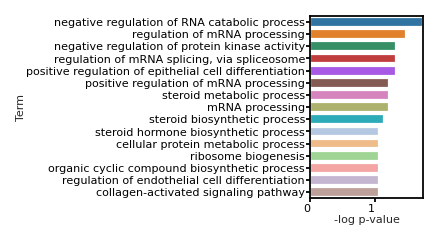

In [596]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=5, facecolor='white', frameon=True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize=(0.9,1.5))
plt.rc('font', size=6)
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
ax.set_axisbelow(True)
plt.grid(b=None)
g = sns.barplot(y = "Term", x = "-log p-value", data= GO_results[0:15], ax=ax)
# from textwrap import wrap
# labels = [x.get_text() for x in ax.get_yticklabels()]
# labels = ['\n'.join(wrap(l, 60)) for l in labels]
# print(labels)
# ax.set_yticklabels(labels, rotation=0, horizontalalignment='right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
ax.set_xlabel("-log p-value", labelpad=0.5)
ax.set_ylabel("Term", labelpad=0.0)
plt.tight_layout()
plt.savefig("./figures/cumulus_early_increase_trends_go.pdf")

In [617]:
trends_df = plot_gene_expression_trends(trends = trends, genes=granulosa_mural_subset.var.loc[clusters[clusters == 3].index.values,:].sort_values(by = "dispersions_norm", ascending = False).index.values[0:10], scale=True)

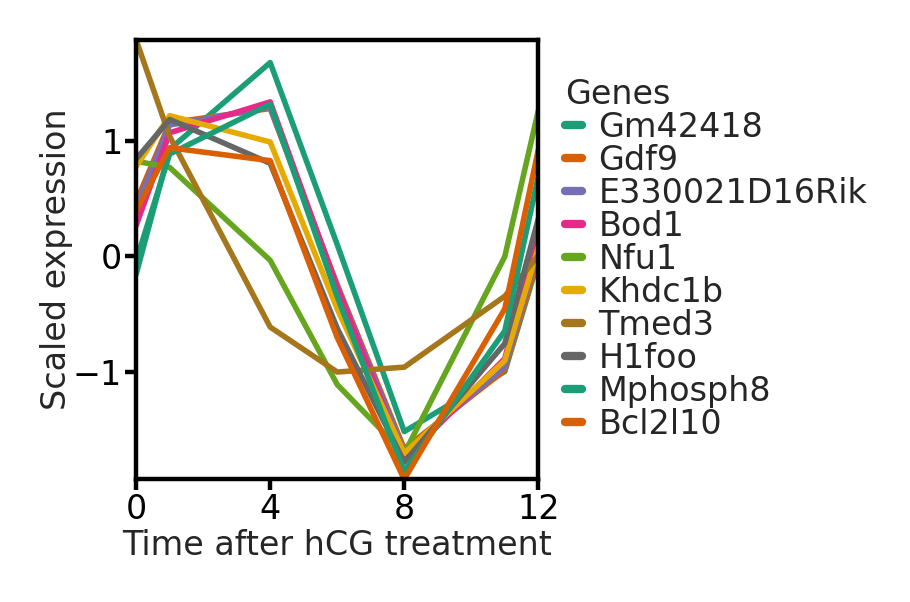

In [618]:
sc.settings.set_figure_params(dpi=200, fontsize=6, facecolor='white', frameon=True, figsize=(5, 5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Gene", palette="Dark2", lw = 1, ax=ax)
g.set_xticks([0,4,8,12])
plt.legend(ncol=1, prop={'size': 6}, loc = 6, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 6, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.5))
ax.get_legend().set_title("Genes")
ax.set_xlabel("Time after hCG treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
fig.savefig("./figures/cumulus_late_increase_trends.pdf")

In [614]:
trends_df = plot_gene_expression_trends(trends = trends, genes=granulosa_mural_subset.var.loc[clusters[clusters == 1].index.values,:].sort_values(by = "dispersions_norm", ascending = False).index.values[0:10], scale=True)

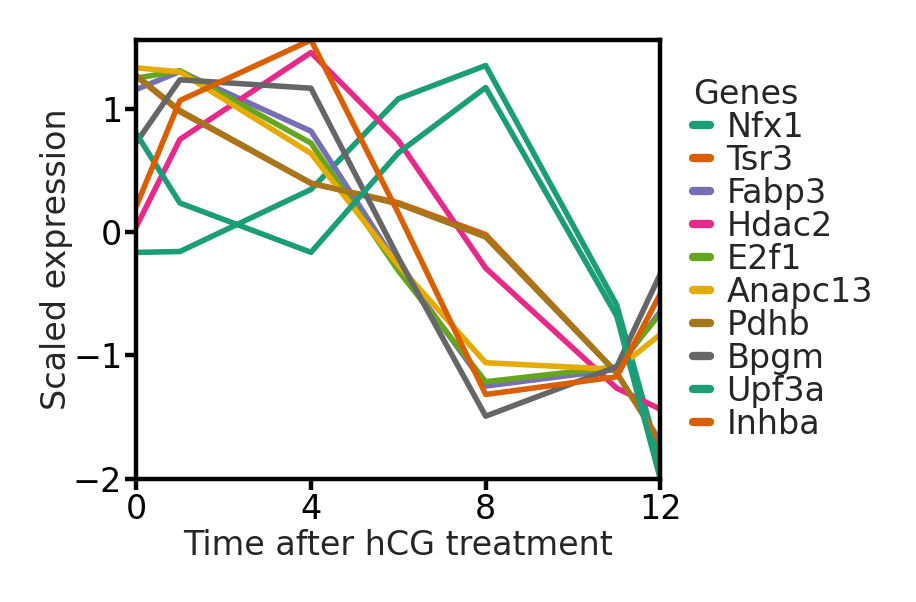

In [615]:
sc.settings.set_figure_params(dpi=200, fontsize=6, facecolor='white', frameon=True, figsize=(5, 5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Gene", palette="Dark2", lw = 1, ax=ax)
g.set_xticks([0,4,8,12])
plt.legend(ncol=1, prop={'size': 6}, loc = 6, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 6, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.5))
ax.get_legend().set_title("Genes")
ax.set_xlabel("Time after hCG treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
fig.savefig("./figures/cumulus_late_decrease_trends.pdf")

In [562]:
granulosa[granulosa.obs["granulosa_celltypes_reduced"] == "GC_Cumulus-(Mixed)"]

View of AnnData object with n_obs × n_vars = 4619 × 31053
    obs: 'barcode', 'x', 'y', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'individual_leiden_1.0', 'individual_leiden_1.2', 'individual_leiden_1.5', 'Sample', 'S_score', 'G2M_score', 'phase', 'leiden_1.0', 'leiden_1.5', 'Level1_total_abundance', 'Level1_EN_Blood', 'Level1_EN_Lymph', 'Level1_Epithelium', 'Level1_GC_Antral', 'Level1_GC_Atretic', 'Level1_GC_CL_Active', 'Level1_GC_CL_Lytic', 'Level1_GC_Estrous', 'Level1_GC_Mitotic', 'Level1_GC_Mural', 'Level1_GC_Preantral', 'Level1_I_B_Cell', 'Level1_I_Dendritic_Cell', 'Level1_I_Granulocyte', 'Level1_I_Macrophage', 'Level1_I_T_Cell', 'Level1_M_Cortical Stroma', 'Level1_M_Dividing Mesenchyme', 'Level1_M_Immature Theca', 'Level1_M_Medullary Stroma', 'Level1_M_Pericyte', 'Level1_M_Smooth Muscle', 'Level1_M_Steroidogenic Theca', 'Level1_Oocyte', 'Level1_max_pred', 'Level1_max_pred_celltype', 'Level1_max_pred_celltype_group', 'Level0_total_abundan

In [619]:
# Load your anndata object
adata = sc.read_h5ad("./../pyobjs/adata_ovary_combined_raw_counts_filtered.h5ad")
adata = adata[granulosa[granulosa.obs["granulosa_celltypes_reduced"] == "GC_Cumulus-(Mixed)"].obs_names]
adata.obs = granulosa[granulosa.obs["granulosa_celltypes_reduced"] == "GC_Cumulus-(Mixed)"].obs
print(adata.shape)

# Set the categorical metadata variable to use for pseudobulk matrix construction
metadata_variable = 'FollicleNumber'

# Get the unique values of the metadata variable
adata.obs[metadata_variable] = adata.obs[metadata_variable].astype(str)
metadata_values = adata.obs[metadata_variable].value_counts().index.values[adata.obs[metadata_variable].value_counts() > 0]

# Initialize an empty dictionary to store the pseudobulk matrices
pseudobulk_dfs = list()

# Loop over each metadata value and create a pseudobulk matrix for each subset of cells
for metadata_value in metadata_values:
    if metadata_value == "nan": 
        continue
    # Subset the anndata object based on the metadata variable
    subset_indices = np.where(adata.obs[metadata_variable] == metadata_value)[0]
    subset_adata = adata[subset_indices, :]

    # Calculate mean expression for each gene across all cells in the subset
    mean_expression = np.sum(subset_adata.X, axis=0)

    # Create a dataframe with gene names as row names and mean expression values as a single column
    pseudobulk_dfs.append(pd.DataFrame(data=mean_expression.T, index=adata.var_names, columns=[metadata_value]))
    
# Create a merged df with pseudobulk expression
pseudobulk_df = pseudobulk_dfs[0].join(pseudobulk_dfs[1:])
print(pseudobulk_df.shape)
del pseudobulk_dfs

(4619, 31053)


/tmp/ipykernel_1212780/2459899961.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[metadata_variable] = adata.obs[metadata_variable].astype(str)


(31053, 170)


In [620]:
mode_df = pd.read_csv("./../pyobjs/follicle_mode.csv")
print(mode_df.shape)
mode_df.columns

(425, 4)


Index(['FollicleNumber', 'Follicle_type', 'Sample', 'size'], dtype='object')

In [621]:
mode_df = granulosa_mural_subset.obs.groupby('FollicleNumber')[['Follicle_type', "Sample"]].apply(lambda x: x.mode()).reset_index()
mode_df["total_counts"] = granulosa_mural_subset.obs.groupby('FollicleNumber')['total_counts'].apply(lambda x: x.sum()).reset_index()["total_counts"]
mode_df = mode_df.drop('level_1', axis=1)
mode_df = mode_df.drop_duplicates(subset='FollicleNumber', keep='first')
mode_df = mode_df.set_index(mode_df["FollicleNumber"])
print(mode_df.shape)

(54, 4)


In [622]:
mode_df = mode_df[~pd.isna(mode_df.Follicle_type)]
mode_df.shape

(54, 4)

In [623]:
import anndata as ad
pseudobulk_df_filtered = pseudobulk_df.loc[:,mode_df.index]
granulosa_mural_bulk = ad.AnnData(X=pseudobulk_df_filtered.T)
granulosa_mural_bulk.obs = mode_df.loc[granulosa_mural_bulk.obs_names,]
granulosa_mural_bulk.obs["ngenes_counts"] = np.sum(pseudobulk_df_filtered != 0.0,)

/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:782: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['Follicle102', 'Follicle120', 'Follicle129', 'Follicle141', 'Follicle142']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [624]:
granulosa_mural_bulk

AnnData object with n_obs × n_vars = 54 × 31053
    obs: 'FollicleNumber', 'Follicle_type', 'Sample', 'total_counts', 'ngenes_counts'

In [625]:
granulosa_mural_bulk.write_h5ad("./../pyobjs/cumulus_bulk_raw_counts.h5ad")

In [626]:
granulosa_mural_bulk = sc.read_h5ad("./../pyobjs/cumulus_bulk_raw_counts.h5ad")
# granulosa_mural_bulk.uns["log1p"]["base"] = None

/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [627]:
granulosa_mural_bulk.obs["Follicle_type"].value_counts()

Antral    54
Name: Follicle_type, dtype: int64

In [628]:
sc.pp.normalize_total(granulosa_mural_bulk, target_sum=1e4)
sc.pp.log1p(granulosa_mural_bulk)

normalizing counts per cell
    finished (0:00:00)


In [629]:
granulosa_mural_bulk.obs["Sample"] = granulosa_mural_bulk.obs["Sample"].astype(str).astype("category")
granulosa_mural_bulk.obs["Sample"] = granulosa_mural_bulk.obs["Sample"].cat.rename_categories({"4hr_replicate" : "4hr"})
granulosa_mural_bulk.obs["Sample"] = granulosa_mural_bulk.obs["Sample"].cat.reorder_categories(["0hr", "1hr", "4hr", "6hr", "8hr", "11hr", "12hr"])

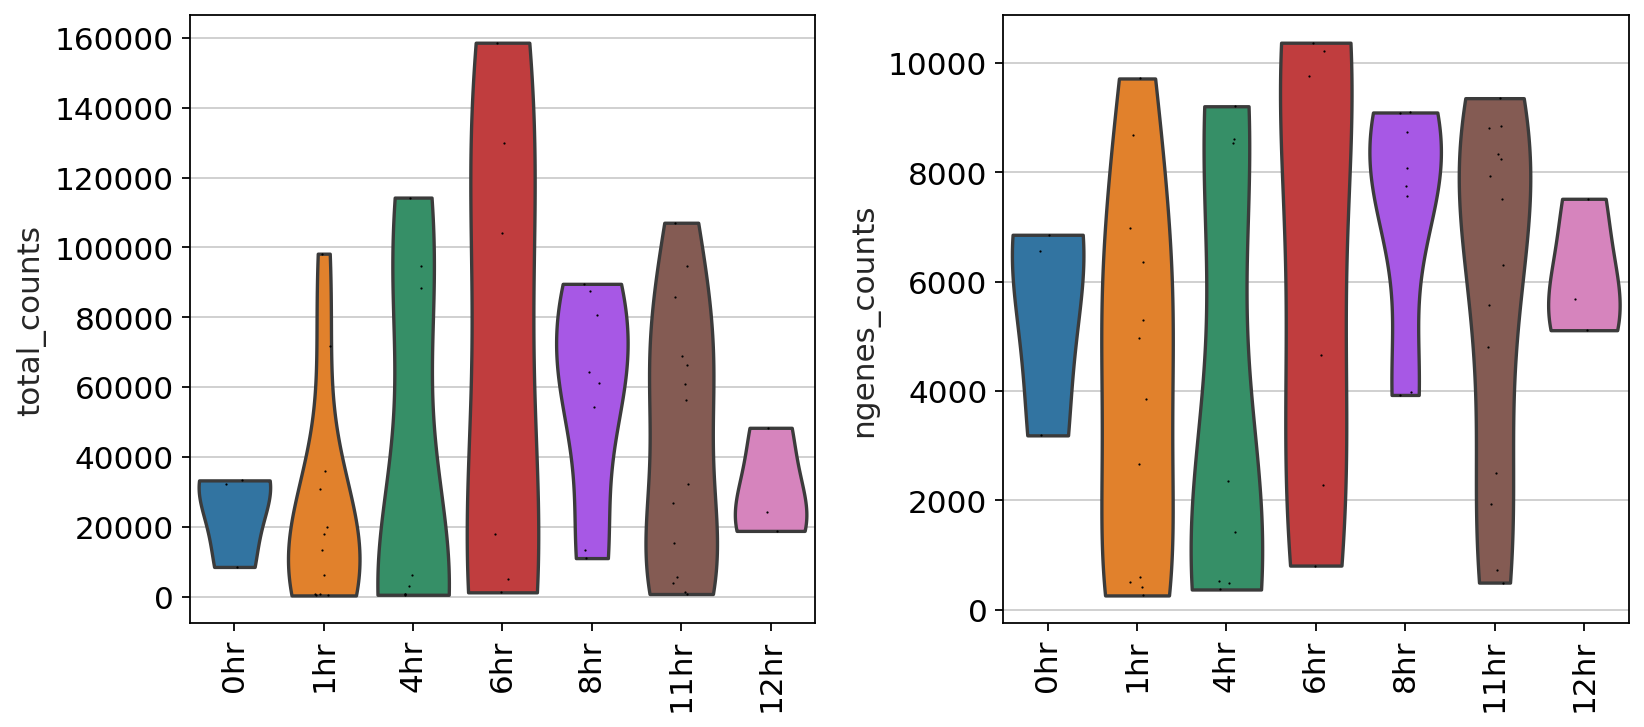

In [630]:
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))
sc.pl.violin(granulosa_mural_bulk, keys=["total_counts", "ngenes_counts"], groupby="Sample", rotation=90)

In [631]:
granulosa_mural_bulk

AnnData object with n_obs × n_vars = 54 × 31053
    obs: 'FollicleNumber', 'Follicle_type', 'Sample', 'total_counts', 'ngenes_counts'
    uns: 'log1p', 'Sample_colors'

In [632]:
granulosa_mural_bulk_subset = granulosa_mural_bulk[granulosa_mural_bulk.obs["Follicle_type"].isin(["Antral"])]
granulosa_mural_bulk_subset.shape

(54, 31053)

In [633]:
granulosa_mural_bulk_subset.obs["timepoint_index"] = granulosa_mural_bulk_subset.obs["Sample"]
celltypes = {#'Immature': 0, 
             '0hr': 1, 
            '1hr': 2, 
             '4hr': 3, 
            '6hr': 4, 
            '8hr': 5,
            '11hr': 6,
           '12hr': 7
}
granulosa_mural_bulk_subset.obs["timepoint_index"] = granulosa_mural_bulk_subset.obs["timepoint_index"].map(celltypes)
granulosa_mural_bulk_subset.obs["timepoint"] = granulosa_mural_bulk_subset.obs["Sample"]
celltypes = {#'Immature': -1, 
             '0hr': 0, 
            '1hr': 1, 
            '4hr': 4, 
            '6hr': 6, 
            '8hr': 8,
            '11hr': 11,
            '12hr': 12
}
granulosa_mural_bulk_subset.obs["timepoint"] = granulosa_mural_bulk_subset.obs["timepoint"].map(celltypes)
granulosa_mural_bulk_subset.obs["timepoint"] = granulosa_mural_bulk_subset.obs["timepoint"].astype(int)

/tmp/ipykernel_1212780/3610544150.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  granulosa_mural_bulk_subset.obs["timepoint_index"] = granulosa_mural_bulk_subset.obs["Sample"]


In [634]:
sc.pp.highly_variable_genes(granulosa_mural_bulk_subset, min_disp=0.5, min_mean=0.5)
gene_list = list(granulosa_mural_bulk_subset.var_names[granulosa_mural_bulk_subset.var.highly_variable])
len(gene_list)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


884

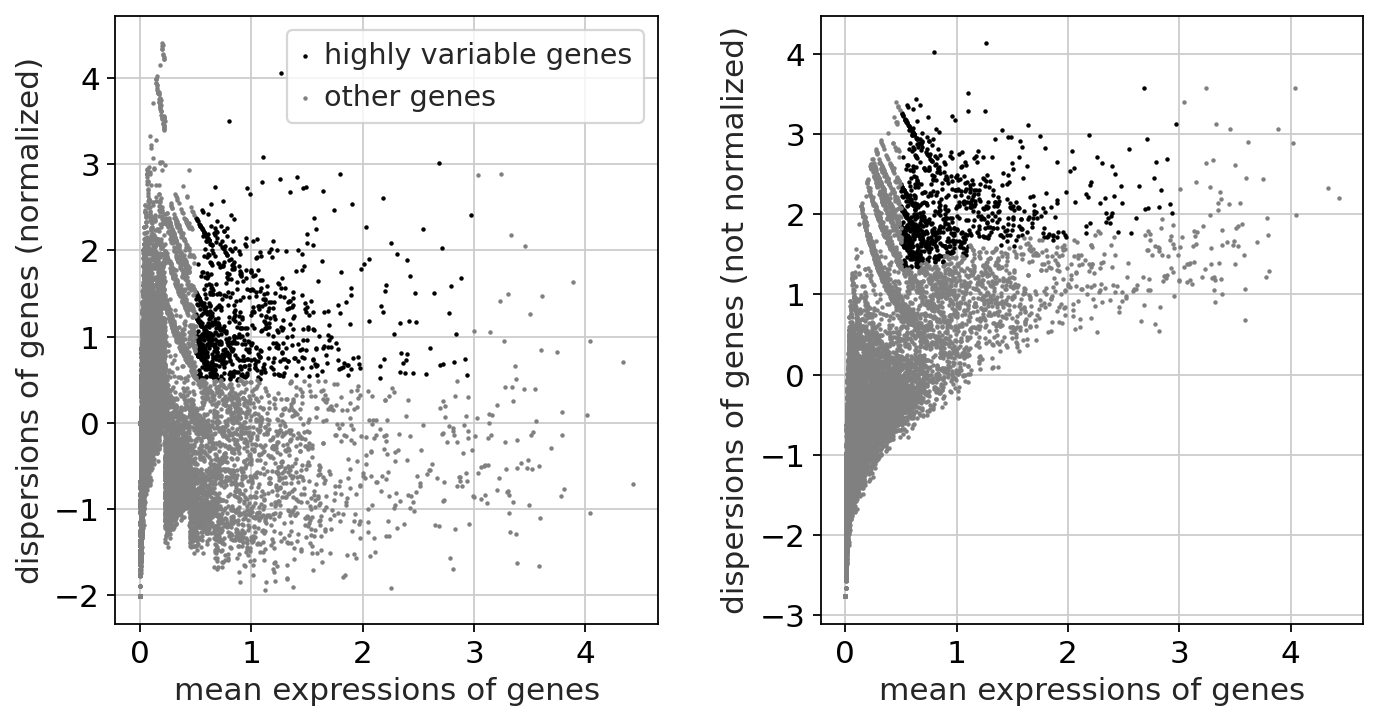

In [635]:
sc.pl.highly_variable_genes(granulosa_mural_bulk_subset)

In [636]:
antral_mural_path = ['Antral']
trend_results = scGAM.compute_gene_trends(granulosa_mural_bulk_subset, var_key="timepoint", genes = gene_list, n_bins = 0, use_raw = False, lineages_paths={"Antral": antral_mural_path}, group_by = "Follicle_type")

Preparing...
Antral :  ['Antral']
Time for processing Antral: 2.6859073797861734 minutes


In [637]:
trends = trend_results['Antral']['trend']

In [638]:
trends.to_csv("./../pyobjs/follicle_cumulus_gene_trends_timepoint_discrete.csv")

In [639]:
trends = pd.read_csv("./../pyobjs/follicle_cumulus_gene_trends_timepoint_discrete.csv", index_col=0)

In [640]:
clusters = scGAM.Agglomerative_cluster_gene_trends_from_lineage(trends, n_clusters=4, scale=True)
clusters.value_counts()

2    251
3    230
0    212
1    191
dtype: int64

In [641]:
trends_df = plot_gene_expression_trend_clusters(trends = trends, cluster_ids=clusters, scale=True)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


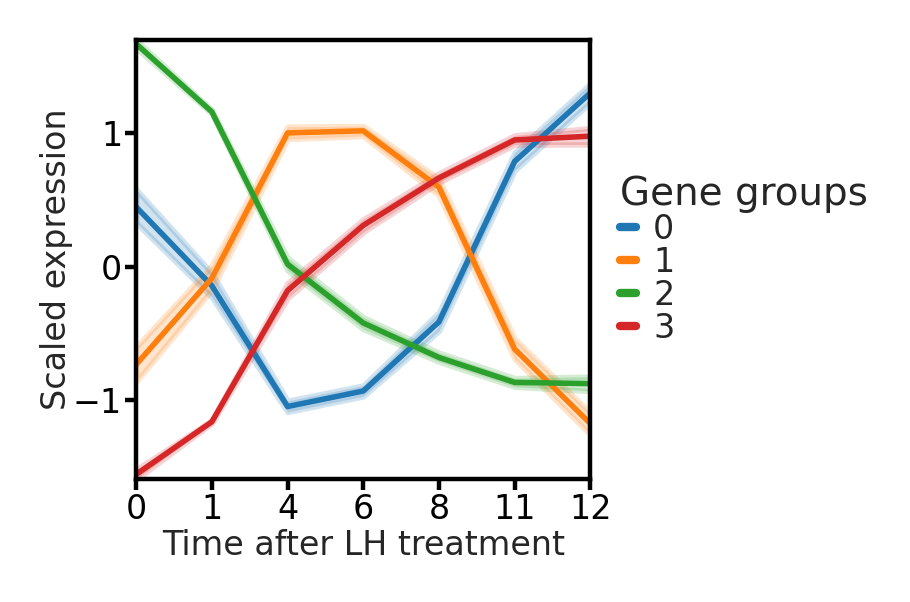

In [642]:
sc.settings.set_figure_params(dpi=200, dpi_save=200, fontsize=6, facecolor='white', frameon=True, figsize=(1.5, 1.5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Cluster", palette="tab10", lw = 1, ax=ax)
plt.legend(ncol=1, prop={'size': 6}, loc = 6, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 7, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.50))
ax.get_legend().set_title("Gene groups")
ax.set_xlabel("Time after LH treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
# fig.savefig("./figures/cumulus_gene_group_trends.pdf")
# plt.show()

In [658]:
clusters.loc["Nupr1"]

2

In [659]:
trends_df = plot_gene_expression_trends(trends = trends, genes=granulosa_mural_bulk_subset.var.loc[clusters[clusters == 3].index.values,:].sort_values(by = "dispersions_norm", ascending = False).index.values[0:10], scale=True)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


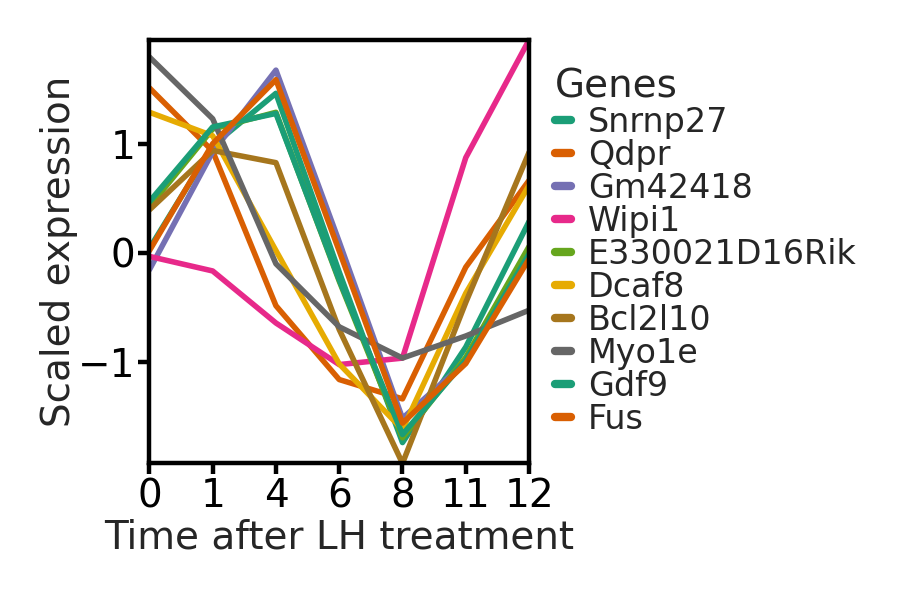

In [660]:
sc.settings.set_figure_params(dpi=200, fontsize=7, facecolor='white', frameon=True, figsize=(5, 5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Gene", palette="Dark2", lw = 1, ax=ax)
# g.set_xticks(range(0, 12, 2))
plt.legend(ncol=1, prop={'size': 6}, loc = 6, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 7, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.50))
ax.get_legend().set_title("Genes")
ax.set_xlabel("Time after LH treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
# fig.savefig("./figures/cumulus_increasing_trends.pdf")

In [544]:
import gseapy
enr_res = gseapy.enrichr(gene_list=list(clusters[clusters == 3].index.values), 
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2021'],
#                      description='pathway', 
                     cutoff = 0.01)

In [657]:
GO_results = enr_res.results
GO_results["-log p-value"] =  -1 * np.log10(GO_results["Adjusted P-value"]) 
GO_results["Term"] = [x.split(" (")[0] for x in GO_results["Term"]]
GO_results[0:20]

Gene_set  \
0   GO_Biological_Process_2021   
1   GO_Biological_Process_2021   
2   GO_Biological_Process_2021   
3   GO_Biological_Process_2021   
4   GO_Biological_Process_2021   
5   GO_Biological_Process_2021   
6   GO_Biological_Process_2021   
7   GO_Biological_Process_2021   
8   GO_Biological_Process_2021   
9   GO_Biological_Process_2021   
10  GO_Biological_Process_2021   
11  GO_Biological_Process_2021   
12  GO_Biological_Process_2021   
13  GO_Biological_Process_2021   
14  GO_Biological_Process_2021   
15  GO_Biological_Process_2021   
16  GO_Biological_Process_2021   
17  GO_Biological_Process_2021   
18  GO_Biological_Process_2021   
19  GO_Biological_Process_2021   

                                                 Term Overlap   P-value  \
0        negative regulation of RNA catabolic process     3/9  0.000017   
1                       regulation of mRNA processing    4/36  0.000063   
2      negative regulation of protein kinase activity    5/90  0.000209   
3        regulation of mRNA splicing, via spliceosome    5/90  0.000209   
4   positive regulation of epithelial cell differe...    3/20  0.000223   
5              positive regulation of mRNA processing    3/23  0.000342   
6                           steroid metabolic process   5/104  0.000410   
7                                     mRNA processing   8/300  0.000459   
8                        steroid biosynthetic process    4/65  0.000629   
9                steroid hormone biosynthetic process    3/31  0.000838   
10                 cellular protein metabolic process   9/417  0.000931   
11                                ribosome biogenesis   6/192  0.001069   
12       organic cyclic compound biosynthetic process    3/34  0.001100   
13     regulation of endothelial cell differentiation     2/9  0.001250   
14               collagen-activated signaling pathway     2/9  0.001250   
15                                     nuclear export    4/84  0.001643   
16                                   bone development    3/40  0.001770   
17             negative regulation of phosphorylation    4/86  0.001792   
18              regulation of RNA export from nucleus    2/12  0.002265   
19               regulation of mRNA metabolic process    2/13  0.002667   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0           0.018010            0                     0   84.931624   
1           0.032699            0                     0   21.387931   
2           0.046582            0                     0   10.125320   
3           0.046582            0                     0   10.125320   
4           0.046582            0                     0   29.959276   
5           0.059518            0                     0   25.461538   
6           0.059982            0                     0    8.687308   
7           0.059982            0                     0    4.791585   
8           0.073052            0                     0   11.203505   
9           0.087105            0                     0   18.179487   
10          0.087105            0                     0    3.869634   
11          0.087105            0                     0    5.572722   
12          0.087105            0                     0   16.417701   
13          0.087105            0                     0   48.118644   
14          0.087105            0                     0   48.118644   
15          0.104020            0                     0    8.534483   
16          0.104020            0                     0   13.751213   
17          0.104020            0                     0    8.325484   
18          0.124597            0                     0   33.677966   
19          0.139340            0                     0   30.614792   

    Combined Score                                              Genes  \
0       931.583054                                 PHAX;SLIRP;ZCCHC17   
1       207.014608                                SON;DHX9;LARP7;IWS1   
2        85.782014  

/tmp/ipykernel_1212780/2256022801.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)
/tmp/ipykernel_1212780/2256022801.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
/tmp/ipykernel_1212780/2256022801.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


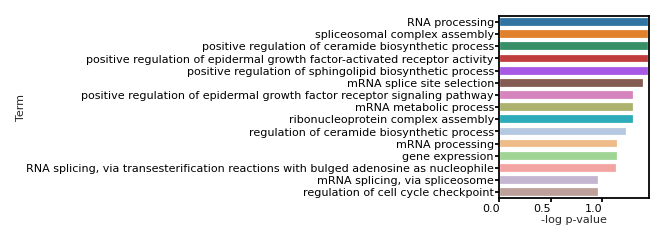

In [540]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=5, facecolor='white', frameon=True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize=(1.2,1.5))
plt.rc('font', size=6)
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
ax.set_axisbelow(True)
plt.grid(b=None)
g = sns.barplot(y = "Term", x = "-log p-value", data= GO_results[0:15], ax=ax)
# from textwrap import wrap
# labels = [x.get_text() for x in ax.get_yticklabels()]
# labels = ['\n'.join(wrap(l, 40)) for l in labels]
# print(labels)
# ax.set_yticklabels(labels, rotation=0, horizontalalignment='right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
ax.set_xlabel("-log p-value", labelpad=0.5)
ax.set_ylabel("Term", labelpad=0.0)
plt.tight_layout()
plt.savefig("./figures/cumulus_increasing_trends_go.pdf")

In [176]:
trends_df = plot_gene_expression_trends(trends = trends, genes=granulosa_mural_bulk_subset.var.loc[clusters[clusters == 0].index.values,:].sort_values(by = "dispersions_norm", ascending = False).index.values[0:10], scale=True)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


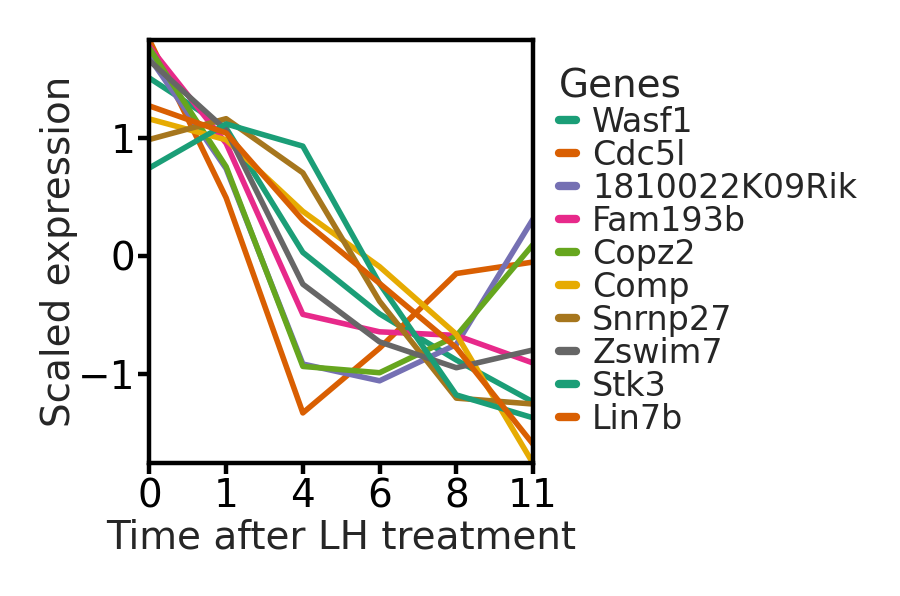

In [177]:
sc.settings.set_figure_params(dpi=200, fontsize=7, facecolor='white', frameon=True, figsize=(5, 5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Gene", palette="Dark2", lw = 1, ax=ax)
# g.set_xticks(range(0, 12, 2))
plt.legend(ncol=1, prop={'size': 6}, loc = 6, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 7, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.50))
ax.get_legend().set_title("Genes")
ax.set_xlabel("Time after LH treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
fig.savefig("./figures/cumulus_decreasing_trends.pdf")

In [178]:
import gseapy
enr_res = gseapy.enrichr(gene_list=list(clusters[clusters == 0].index), 
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2021'],
#                      description='pathway', 
                     cutoff = 0.01)

In [179]:
GO_results = enr_res.results
GO_results["-log p-value"] =  -1 * np.log10(GO_results["Adjusted P-value"]) 
GO_results["Term"] = [x.split(" (")[0] for x in GO_results["Term"]]
GO_results[0:10]

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   
5  GO_Biological_Process_2021   
6  GO_Biological_Process_2021   
7  GO_Biological_Process_2021   
8  GO_Biological_Process_2021   
9  GO_Biological_Process_2021   

                                               Term Overlap   P-value  \
0                      transcription, DNA-templated  10/221  0.000125   
1  RNA polymerase II preinitiation complex assembly    3/10  0.000132   
2      transcription preinitiation complex assembly    3/13  0.000306   
3          snRNA transcription by RNA polymerase II    5/70  0.000865   
4                               snRNA transcription    5/71  0.000922   
5                                   mRNA processing  10/300  0.001367   
6                                   gene expression  11/356  0.001464   
7           protein import into peroxisome membrane    3/22  0.001537   
8                                protein alkylation    3/23  0.001754   
9           DNA-templated transcription, initiation   7/168  0.002079   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.084769            0                     0    4.616255   
1          0.084769            0                     0   40.759615   
2          0.131574            0                     0   28.527404   
3          0.237800            0                     0    7.365198   
4          0.237800            0                     0    7.253236   
5          0.247719            0                     0    3.345171   
6          0.247719            0                     0    3.099768   
7          0.247719            0                     0   15.007591   
8          0.251267            0                     0   14.256490   
9          0.259690            0                     0    4.183291   

   Combined Score                                              Genes  \
0       41.497836  IVNS1ABP;GTF2A1;PPP5C;CDK7;GTF2A2;RRAGC;NCOA6;...   
1      364.240236                                  GTF2A2;GTF2B;TAF1   
2      230.820889                                  GTF2A2;GTF2B;TAF1   
3       51.947008                    GTF2A1;GTF2A2;CDK7;GTF2B;POLR2C   
4       50.689308                    GTF2A1;GTF2A2;CDK7;GTF2B;POLR2C   
5       22.061608  TCERG1;CPSF7;CDK7;SNRPD2;HNRNPF;POLR2C;SNRNP27...   
6       20.230400  RBM3;PPP5C;RRAGC;NUP85;HNRNPF;POLR2C;MRPL37;AA...   
7       97.213790                                ALDH3A2;PXMP4;PEX13   
8       90.466506                             FAM98A;EEF1AKMT2;LCMT1   
9       25.835099         GTF2A1;CDK7;GTF2A2;NCOA6;GTF2B;POLR2C;TAF1   

   -log p-value  
0      1.071764  
1      1.071764  
2      0.880831  
3      0.623788  
4      0.623788  
5      0.606041  
6      0.606041  
7      0.606041  
8      0.599865  
9      0.585545

['protein import into peroxisome membrane', 'peroxisomal membrane transport', 'protein targeting to peroxisome', 'estrogen biosynthetic process', 'fatty acid alpha-oxidation', 'organic cyclic compound biosynthetic\nprocess', 'glycine transport', 'RNA polymerase II preinitiation complex\nassembly', 'protein import', 'transcription preinitiation complex\nassembly']


/tmp/ipykernel_1212780/1868843139.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)
/tmp/ipykernel_1212780/1868843139.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
/tmp/ipykernel_1212780/1868843139.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


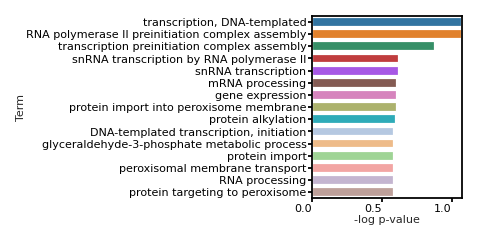

In [180]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=5, facecolor='white', frameon=True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize=(1.2,1.5))
plt.rc('font', size=6)
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
ax.set_axisbelow(True)
plt.grid(b=None)
g = sns.barplot(y = "Term", x = "-log p-value", data= GO_results[0:15], ax=ax)
# from textwrap import wrap
# labels = [x.get_text() for x in ax.get_yticklabels()]
# labels = ['\n'.join(wrap(l, 40)) for l in labels]
print(labels)
# ax.set_yticklabels(labels, rotation=0, horizontalalignment='right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
ax.set_xlabel("-log p-value", labelpad=0.5)
ax.set_ylabel("Term", labelpad=0.0)
plt.tight_layout()
plt.savefig("./figures/cumulus_decreasing_trends_go.pdf")

In [553]:
trends_df = plot_gene_expression_trends(trends = trends, genes=granulosa_mural_bulk_subset.var.loc[clusters[clusters == 1].index.values,:].sort_values(by = "dispersions_norm", ascending = False).index.values[1:10], scale=True)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


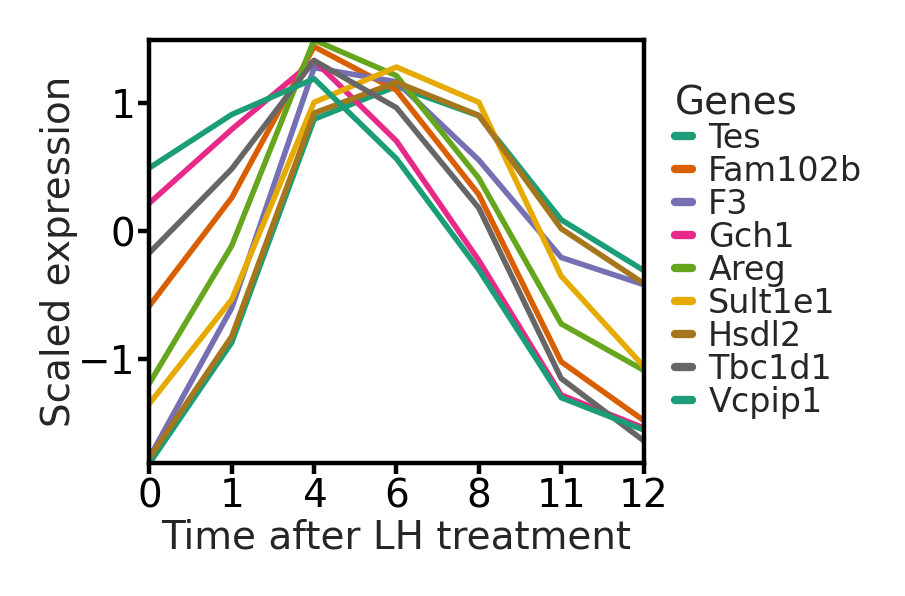

In [554]:
sc.settings.set_figure_params(dpi=200, fontsize=7, facecolor='white', frameon=True, figsize=(5, 5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Gene", palette="Dark2", lw = 1, ax=ax)
# g.set_xticks(range(0, 12, 2))
plt.legend(ncol=1, prop={'size': 6}, loc = 6, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 7, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.50))
ax.get_legend().set_title("Genes")
ax.set_xlabel("Time after LH treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
fig.savefig("./figures/cumulus_early_increasing_trends.pdf")

In [555]:
import gseapy
enr_res = gseapy.enrichr(gene_list=list(clusters[clusters == 1].index), 
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2021'],
#                      description='pathway', 
                     cutoff = 0.01)

In [556]:
GO_results = enr_res.results
GO_results["-log p-value"] =  -1 * np.log10(GO_results["Adjusted P-value"]) 
GO_results["Term"] = [x.split(" (")[0] for x in GO_results["Term"]]
GO_results[0:10]

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   
5  GO_Biological_Process_2021   
6  GO_Biological_Process_2021   
7  GO_Biological_Process_2021   
8  GO_Biological_Process_2021   
9  GO_Biological_Process_2021   

                                                Term Overlap   P-value  \
0                                     RNA processing   9/179  0.000058   
1                      spliceosomal complex assembly    5/46  0.000075   
2  positive regulation of ceramide biosynthetic p...    3/11  0.000134   
3  positive regulation of epidermal growth factor...    3/11  0.000134   
4  positive regulation of sphingolipid biosynthet...    3/11  0.000134   
5                         mRNA splice site selection    4/30  0.000182   
6  positive regulation of epidermal growth factor...    4/34  0.000299   
7                             mRNA metabolic process    6/95  0.000301   
8                 ribonucleoprotein complex assembly   7/136  0.000336   
9        regulation of ceramide biosynthetic process    3/16  0.000438   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.034790            0                     0    5.712702   
1          0.034790            0                     0   12.960923   
2          0.034790            0                     0   39.496676   
3          0.034790            0                     0   39.496676   
4          0.034790            0                     0   39.496676   
5          0.039433            0                     0   16.275607   
6          0.048544            0                     0   14.102674   
7          0.048544            0                     0    7.186152   
8          0.048544            0                     0    5.803842   
9          0.056994            0                     0   24.299509   

   Combined Score                                              Genes  \
0       55.776301  ZRSR2;SYNCRIP;NUDT21;CPSF6;PRPF3;PABPC4;WBP4;S...   
1      123.069089                    ZRSR2;LUC7L;SRSF10;LUC7L2;SRSF9   
2      352.305737                                  SMPD2;PRKCD;NSMAF   
3      352.305737                                      BTC;AREG;EREG   
4      352.305737                                  SMPD2;PRKCD;NSMAF   
5      140.170273                          LUC7L;SRSF10;LUC7L2;SRSF9   
6      114.457829                                 BTC;DOK1;AREG;EREG   
7       58.261365                  NUDT21;CPSF6;SSB;PRPF3;EREG;SRSF9   
8       46.424648       ZRSR2;NUDT21;CPSF6;LUC7L;SRSF10;LUC7L2;SRSF9   
9      187.910721                                  SMPD2;PRKCD;NSMAF   

   -log p-value  
0      1.458549  
1      1.458549  
2      1.458549  
3      1.458549  
4      1.458549  
5      1.404145  
6      1.313865  
7      1.313865  
8      1.313865  
9      1.244169

In [557]:
granulosa_mural_bulk_subset.write_h5ad("./../pyobjs/cumulus_bulk_processed.h5ad")
granulosa_mural_bulk_subset

AnnData object with n_obs × n_vars = 54 × 31053
    obs: 'FollicleNumber', 'Follicle_type', 'Sample', 'total_counts', 'ngenes_counts', 'timepoint_index', 'timepoint'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'Sample_colors', 'hvg'

In [343]:
granulosa_mural_bulk_subset = sc.read_h5ad("./../pyobjs/cumulus_bulk_processed.h5ad")
granulosa_mural_bulk_subset

AnnData object with n_obs × n_vars = 42 × 31053
    obs: 'FollicleNumber', 'Follicle_type', 'Sample', 'total_counts', 'ngenes_counts', 'timepoint_index', 'timepoint'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Sample_colors', 'hvg', 'log1p'

In [182]:
granulosa_mural_bulk_subset.obs["Sample"].value_counts()

11hr    14
1hr     12
4hr      8
8hr      8
6hr      5
0hr      3
Name: Sample, dtype: int64

In [183]:
freq_table = granulosa_mural_bulk_subset.obs.groupby(['Sample', 'Follicle_type']).size().reset_index(name='count')
freq_table['total_count'] = freq_table.groupby(["Sample"])['count'].transform('sum')
freq_table['proportion'] = freq_table['count'] / freq_table['total_count']
freq_table["Sample"] = freq_table["Sample"].astype("category")
freq_table["Sample"] = freq_table["Sample"].cat.reorder_categories(["0hr", "1hr", "4hr", "6hr", "8hr", "11hr"])
freq_table["Follicle_type"] = freq_table["Follicle_type"].astype("category")
freq_table["Follicle_type"] = freq_table["Follicle_type"].cat.reorder_categories(["Preantral", "Antral", "Atretic", "Lytic"])
# freq_table["Follicle_type"] = freq_table["Follicle_type"].cat.remove_categories(["Transitioning"])

ValueError: items in new_categories are not the same as in old categories

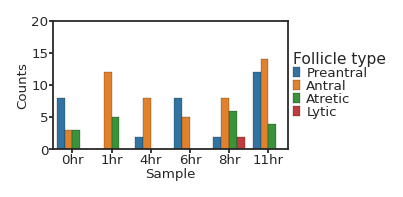

In [189]:
sc.settings.set_figure_params(dpi=80, fontsize=6, facecolor='white', frameon=False, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (2.5,1.2))
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0, size = 2)
sns.barplot(freq_table, y = "count", x = "Sample", hue="Follicle_type",  dodge=True, palette="tab10", ax=ax, 
           linewidth=0.1, edgecolor="black")
plt.legend(ncol=1, prop={'size': 6}, handletextpad=0.5, markerscale = 0.5, title = "Follicle type",
           labelspacing = 0.0, frameon = False,  title_fontsize = 7, alignment = "left", loc = 6, 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.01, 0.5))
plt.rcParams['legend.title_fontsize'] = 9
ax.set_ylim(0,20)
ax.set_ylabel("Counts", labelpad = 1.0)
ax.set_xlabel("Sample", labelpad = 0.5)
plt.tight_layout()
plt.savefig("./figures/cumulus_follicle_type_stats.pdf")